# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#%autoreload

import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_extract
from pyspark.sql.types import FloatType, IntegerType

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

In [3]:
# load the data in spark
df_s = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df_s.createOrReplaceTempView("df_table")

In [5]:
df_s.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df_s.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

The approach will consider the `page` and the `ts` column. The assumption is that I can use a window to aggregate some features in order to predict whether a user will churn or not.

TODO:
- Which features:
    - Average session duration for each user
    - Average listening time of a song
    - Average sessions per day
    - Average sessions per Month
- What does churn mean
- How long should the window be

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Clean the column names and index

The values in the csv are structured like key:value. The key has to be extracted and defined as the column name. The values have to be converted to the correct data type.

In [7]:
df = df_s.toPandas()

In [8]:
df.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
273796,None,Logged In,Antonina,F,0,Kennedy,NaN,paid,"Colorado Springs, CO",GET,Home,1.526739e+12,339,None,200,1541671300000,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001
27540,Mansun,Logged In,Jayden,F,26,Phillips,249.07710,free,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1.537893e+12,601,Stripper Vicar,200,1539116277000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",118
158229,Ron Carter,Logged In,Riley,F,15,Taylor,497.13587,paid,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.536404e+12,1947,I CAN'T GET STARTED,200,1542284397000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",92
154300,Travie McCoy,Logged In,Chayse,M,86,Keller,211.12118,paid,"Jackson, MS",PUT,NextSong,1.529643e+12,1905,Billionaire [feat. Bruno Mars] (Explicit Albu...,200,1542186037000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",70
228251,None,Logged In,Zoey,F,92,Floyd,NaN,free,"Chicago-Naperville-Elgin, IL-IN-WI",PUT,Add to Playlist,1.530333e+12,28,None,200,1538749960000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",200003


In [9]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

In [11]:
def get_unique_values(table_name, col_name):
    """
    Computes a list of unique values of the given
    table on the given column and returns a list.
    INPUT:
        table_name (str): name of the input table
        col_name (str): name of the column to search unique values
    OUTPUT:
        list (str): all unique values found
    """
    res = spark.sql("""
          SELECT DISTINCT {col_name}
          FROM {table_name}
          """.format(table_name=table_name,
                     col_name=col_name)).toPandas().values.flatten().tolist()
    return res

In [12]:
# Print unique values of interesting columns
unique_query_cols = ['auth', 'level', 'status', 'userAgent', 'gender']
for col in unique_query_cols:
    res = get_unique_values('df_table', col)
    print("Column '{}' has the {} following unique values:\n".format(col, len(res)), res)

Column 'auth' has the 4 following unique values:
 ['Logged Out', 'Cancelled', 'Guest', 'Logged In']
Column 'level' has the 2 following unique values:
 ['free', 'paid']
Column 'status' has the 3 following unique values:
 [307, 404, 200]
Column 'userAgent' has the 57 following unique values:
 ['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/201001

#### Clean the userAgent column

This column contains a lot details that are most likely not relevant. However, the device type / OS type could be relevant, thus we extract it.

In [13]:
"""
Extract the user system from the userAgent column. Raw regexp that is applied:

Note: External braces need to be escaped with three backslashes for the sql query.
"""
userSystem = spark.sql('''
          SELECT *, regexp_extract(userAgent,
                                \"\\\(([a-zA-Z 0-9.]+)\", 1)
                                as userSystem
          FROM df_table
          ''')
userSystem.createOrReplaceTempView("df_table")

## Delete unnecessary columns

Downselect some interesting columns.

TODO: What is the exact justification of other columns to be excluded? Iterative approach? How can we assess the degree of information the columns have?

In [14]:
df_s = spark.sql('''
                 SELECT userId, page, level, sessionId, ts, itemInSession, userSystem, length, auth
                 FROM df_table
                 ''')
df_s.createOrReplaceTempView("df_table")

In [15]:
df = df_s.toPandas()

In [16]:
# Convirm that there are no missing values
df.isna().any()

userId           False
page             False
level            False
sessionId        False
ts               False
itemInSession    False
userSystem        True
length            True
auth             False
dtype: bool

In [17]:
df.head()

,userId,page,level,sessionId,ts,itemInSession,userSystem,length,auth
0,30,NextSong,paid,29,1538352117000,50,Windows NT 6.1,277.89016,Logged In
1,9,NextSong,free,8,1538352180000,79,Windows NT 6.1,236.09424,Logged In
2,30,NextSong,paid,29,1538352394000,51,Windows NT 6.1,282.82730,Logged In
3,9,NextSong,free,8,1538352416000,80,Windows NT 6.1,262.71302,Logged In
4,30,NextSong,paid,29,1538352676000,52,Windows NT 6.1,223.60771,Logged In


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [18]:
"""
Define a column `churn` that is 0 before a `Cancellation Confirmation` and 1 afterwards.

Calculation logic:
- binary encoding of the events
- cumulative sum over the binary encoding
"""
# binary encoding of the 'Cancellation Confirmation' events in column churn
df_s = spark.sql('''
                  SELECT *, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END as cancel_event
                  FROM df_table
                  ''')
df_s.createOrReplaceTempView('df_table')

In [19]:
# cumulative sum over the churn column to detect phases
df_s = spark.sql('''
          SELECT *,
          SUM(cancel_event) OVER (PARTITION BY userId) as churn
          FROM df_table
          ''')
df_s.createOrReplaceTempView("df_table")

### Get userId of loyal and churned users

Prepare two tables of `userId` separated by the fact whether this is a user that churned or a loyal user. This information is later needed to explore the daa based on the user group.

In [20]:
# Collect all userId of users that cancelled the subscription
cancelled_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) > 0
                          ''')
cancelled_userIds.createOrReplaceTempView("cancelled_userIds")

# print statistics
print("Overall {} users cancelled their subscription.".format(len(cancelled_userIds.collect())))

Overall 52 users cancelled their subscription.


In [21]:
# Collect all userId of users that cancelled the subscription
loyal_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) = 0
                          ''')
loyal_userIds.createOrReplaceTempView("loyal_userIds")

# print statistics
print("Overall {} users did not cancel their subscription.".format(len(loyal_userIds.collect())))

Overall 174 users did not cancel their subscription.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Ideas for comparing the two groups:
- For each group, the average count of interactions per session. This will help us to understand whether users with less action count per session are more suspicios of churning.
- For each group, the average count of each page in a session. This will help us to understand whether the user behaviour within a session distinguishes the two groups.

#### Average length

The `length` event is filled out for `NextSong` and indicates the length of the played song. The listening behaviour could carry information about whether a user might `churn` or not.

In [90]:
# Extract the average length for both groups
lengths_pd = spark.sql('''
          SELECT userId, churn, avg(length)
          FROM df_table
          GROUP BY userId, churn
          ''').toPandas()

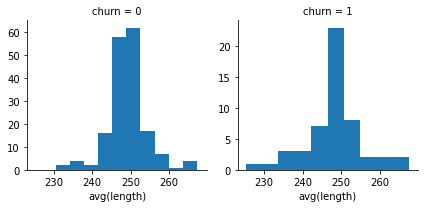

In [91]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(lengths_pd, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

Both distributions follow a different shape. Thus this feature will be included into the feature extraction process.

#### Items per session

The items per session can carry information about how intensively a user interacts with the portal and also about the session length. This could also contribute to explain the `churn`.

In [96]:
# For each user for each session, extract the average number of items to Pandas
items_per_sess_pd = spark.sql('''
          SELECT churn, userId, AVG(itemInSession) as avg
          FROM df_table
          GROUP BY churn, userId
          ''').toPandas()

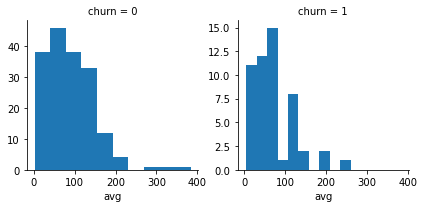

In [98]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(items_per_sess_pd, col="churn", sharey=False)
g.map(plt.hist, "avg");

The distribution of average events is more skewed for users that churned, indicating that this feature also carries information about a potential `churn`.

#### Average sessions per day

The average sessions per day is counted by dividing the overall session count of a given user by the number of days from the first event observed until the last event observed.

In [99]:
# Add the feature for average sessions per day
avg_sess_per_day = """
                   SELECT churn, userId, COUNT(DISTINCT sessionId) / (to_days(MAX(ts) - MIN(ts))+1) as avg_sess_p_day
                   FROM df_table
                   GROUP BY churn, userId
                   """
avg_sess_p_day_pd = spark.sql(avg_sess_per_day).toPandas()

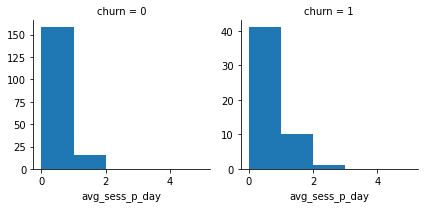

In [111]:
import numpy as np
bins = np.arange(0, 6, 1)

g = sns.FacetGrid(data=avg_sess_p_day_pd, col="churn", sharey=False)
g.map(plt.hist, "avg_sess_p_day", bins=bins)

The distribution for churned users tends to have a fatter tail. It can be assumed that this feature also contributes to the classification process.

#### Daytime of service usage

The daytime when the service is used might tell something about the potential of a user to churn. For example, users that frequently use the service in the evening might have a different churn rate than users that rather tend to use the service in the office or during lunch.

In [27]:
to_hour = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).hour), FloatType())
spark.udf.register("to_hour", to_hour)

<function __main__.<lambda>(x)>

In [28]:
# Add a column 'hour' to the data based on the timestamp 'ts'
hours_augmented = spark.sql('''
                   SELECT *, to_hour(ts) as hour
                   FROM df_table
                   ''')
hours_augmented.createOrReplaceTempView("df_table_hours")

In [29]:
def get_bucket_percentage(table, time_col, uid_table):
    """
    Returns a Pandas DataFrame which shows for a given user group 
    the percentage of actions during time bucket in column 'col'. This function
    is used to compute the data for loyal and churned users seperately.
    INPUT:
        table (str): name of a table view that contains the 'time_col' column and a 'userId' colummn
        time_col (str): name of the time column, i.e. 'weekday' or 'hour'
        userId_list (str): name of a table that contain a column userId only.
    OUTPUT:
        Pandas DataFrame which shows the total number of events per time bucket for the given user group
    """
    res = spark.sql("""
                    SELECT {time_col}, COUNT({time_col}) / (SELECT COUNT(*) FROM {table} WHERE userId IN (SELECT * FROM {uid_table})) as count 
                    FROM {table}  
                    WHERE userId IN (SELECT * FROM {uid_table})
                    GROUP BY {time_col}
                    ORDER BY count DESC 
                    """.format(uid_table=uid_table, time_col=time_col, table=table))
    res_pd = res.toPandas()
    return res_pd

In [30]:
loyal_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'loyal_userIds')
churn_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'cancelled_userIds')

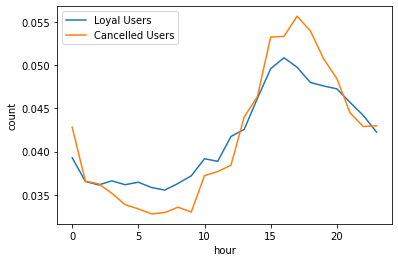

In [31]:
ax = sns.lineplot(x='hour', y='count', data=loyal_hours_pd, label='Loyal Users')
ax = sns.lineplot(x='hour', y='count', data=churn_hours_pd, label='Cancelled Users')
plt.show()

The data shows that `loyal` users are more active during the morning hours and `cancelled` users tend to have a relatively higher activity during the afternoon.

#### Weekday of service usage

The weekday might also play a role to distinguish users that churn from loyal users. For example, users that tend to use the service during workdays might have a different probability to churn than users that use the service during the weekend.

In [32]:
to_day = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).weekday()), FloatType())
spark.udf.register("to_day", to_day)

<function __main__.<lambda>(x)>

In [33]:
# Add a column 'weekday' to the data based on the timestamp 'ts'
weekdays_augmented = spark.sql('''
                   SELECT *, to_day(ts) as weekday
                   FROM df_table
                   ''')
weekdays_augmented.createOrReplaceTempView("df_table_weekdays")

In [34]:
loyal_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'loyal_userIds')
churn_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'cancelled_userIds')

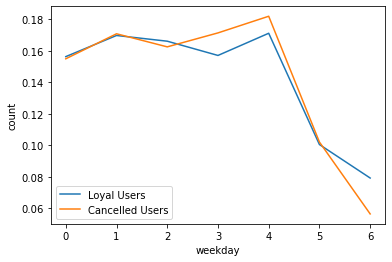

In [35]:
ax = sns.lineplot(x='weekday', y='count', data=loyal_weekdays_pd, label='Loyal Users')
ax = sns.lineplot(x='weekday', y='count', data=churn_weekdays_pd, label='Cancelled Users')
plt.show()

The percentage of usage follows a very similar line, however, cancelled users tend to listen more on Thursday and Friday, while loyal users tend to listen more on Sunday.

#### User system distribution

The type of user agent could play a role with regards to the churn rage, for example if the experience on a smartphone device is worse than on other devices. 

In [36]:
# Extract the DataFrams for loyal and cancelled users
loyal_systems_pd = get_bucket_percentage('df_table', 'userSystem', 'loyal_userIds')
cancelled_systems_pd = get_bucket_percentage('df_table', 'userSystem', 'cancelled_userIds')

In [37]:
cancelled_systems_pd

,userSystem,count
0,Macintosh,0.386836
1,Windows NT 6.1,0.364502
2,Windows NT 6.3,0.090652
3,Windows NT 5.1,0.048324
4,Windows NT 6.2,0.047900
5,X11,0.039274
6,iPhone,0.022512


In [38]:
loyal_systems_pd

,userSystem,count
0,Macintosh,0.353399
1,Windows NT 6.1,0.343612
2,Windows NT 6.3,0.059854
3,iPad,0.047100
4,compatible,0.044215
5,iPhone,0.042138
6,X11,0.029793
7,Windows NT 5.1,0.021677
8,Windows NT 6.2,0.013566
9,Windows NT 6.0,0.010106


In [39]:
system_usage = loyal_systems_pd.merge(cancelled_systems_pd, on='userSystem', how='outer', suffixes=('_loyal', '_cancelled'),).fillna(0.0)

In [40]:
system_usage.userSystem = system_usage.userSystem.replace({"":"unknown"})

In [41]:
# Melt the data down to three columns
df = pd.melt(system_usage, id_vars="userSystem", var_name="type", value_name="percentage")
df = df.rename(columns={"count_loyal":"Loyal Users",
                   "count_cancelled":"Cancelled Users",
                   "type":"User Category",
                   "userSystem":"User System",
                   "percentage":"Percentage"})

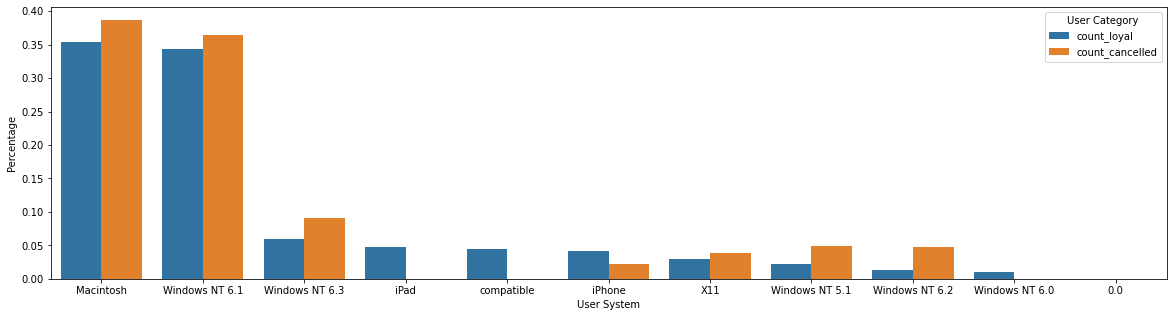

In [42]:
fig = plt.figure(figsize=(20,5))
sns.barplot(y='Percentage', x='User System', hue='User Category', data = df)

Loyal users tend to use the iPad, iPad and compatible more often than users that cancelled. Maybe the user experience is better than the desktop app, or people prefer to listen to music en route.

#### Length of the trace

The length of the trace helps to undertand the data. The idea is to compare the first and last timestamp of each user.

In [43]:
to_days = udf(lambda x: datetime.timedelta(milliseconds=x).days, IntegerType())
spark.udf.register("to_days", to_days)

<function __main__.<lambda>(x)>

In [44]:
# Calculate the account lifetime in days
lifetimes = spark.sql('''
                      SELECT userId, to_days(MAX(ts) - MIN(ts)) as lifetime
                      FROM df_table
                      GROUP BY userId
                      ORDER BY userId ASC
                      ''')
lifetimes.createOrReplaceTempView("lifetime_table")

In [45]:
def ntile_breakdown(ntile, ntile_col, userid_table, table='lifetime_table'):
    """
    Calculates the NTILES over a given column.
    INPUT:
        ntile (int): ntile, i.e. 4 for quartiles
        ntile_col (string): name of the column to compute ntiles on
        userid_table (string): table that contains userIds we are interested in
        table (string): name of a temp view that contains the column 'ntile_col'
    Output:
        result (DataFrame): Pandas DataFrame with the columns 'ntile_col' and 'ntiles'
    """
    res = spark.sql("""
          SELECT {ntile_col}, NTILE({ntile}) OVER(ORDER BY {ntile_col} ASC) AS ntiles 
          FROM {table}
          WHERE userId IN (SELECT * FROM {userid_table})
          """.format(ntile=ntile,
                     ntile_col=ntile_col,
                     userid_table=userid_table,
                     table=table))
    res.createOrReplaceTempView("ntiles_view") 
    
    res = spark.sql("""
            SELECT ntiles, MAX({ntile_col}) as value
            FROM ntiles_view
            GROUP BY ntiles
            """.format(ntile_col=ntile_col))
    return res.toPandas()

In [46]:
def merge_and_melt_dfs(df_loyal, df_cancelled, on):
    """
    Merges and melts two DataFrames that were seperately created for loyal
    and cancelled users. The column names need to match in both tables. Both
    tables need to contain the column 'on'.
    INPUT:
        df_loyal (DataFrame): DataFrame created for users that were loyal
        df_canelled (DataFrame): DataFrame created for users that cancelled
        on (string): column name to merge the two DataFrames on
    OUTPUT:
        result (DataFrame): merged and melted pandas DataFrame
    
    """
    tmp_df = df_loyal.merge(df_cancelled,
                            on=on,
                            how='outer',
                            suffixes=('_loyal', '_cancelled'),).fillna(0.0)
    
    # Melt the data down to three columns
    res_df = pd.melt(tmp_df, id_vars=on, var_name="User Category", value_name="Value")
    res_df = res_df.rename(columns={on:on.capitalize()})
    
    return res_df

In [47]:
loyal_users_ntiles_pd = ntile_breakdown(4, 'lifetime', 'loyal_userIds')
cancelled_users_ntiles_pd = ntile_breakdown(4, 'lifetime', 'cancelled_userIds')

In [48]:
ntiles_pd = merge_and_melt_dfs(loyal_users_ntiles_pd,
                                cancelled_users_ntiles_pd,
                                on='ntiles')

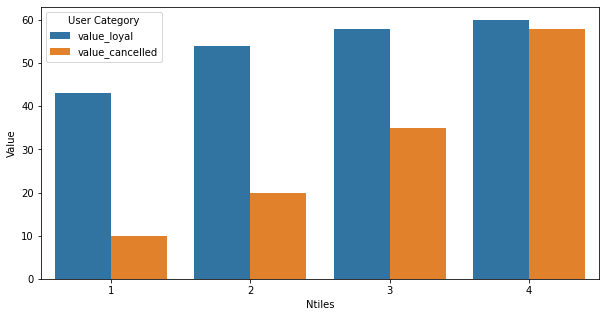

In [49]:
fig = plt.figure(figsize=(10,5))
sns.barplot(y='Value', x='Ntiles', hue='User Category', data = ntiles_pd)

In [170]:
acc_age = spark.sql("""
                  SELECT churn, userId, to_days(MAX(ts) - MIN(ts)) as acc_age
                  FROM df_table
                  GROUP BY churn, userId
                  """).toPandas()

The distribution of the quartiles clearly states that the cancelled user accounts generally have a shorter lifetime. For example:
- 50% of cancelled users have an account lifetime of 20 days or less
- 50% of loyal users have an account lifetime of approx. 52 days or less

Accordingly it follows, that the account lifetime will be an important feature to detect the `churn`.

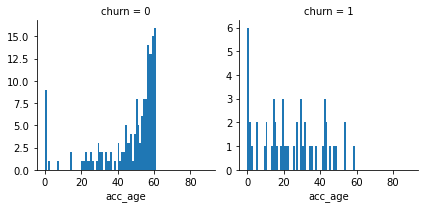

In [172]:
bins = np.arange(0, 90, 1)

g = sns.FacetGrid(acc_age, col="churn", sharey=False)
g.map(plt.hist, "acc_age", bins=bins)

It seems that users cancel uniform distributed over the lifetime of the account. However, when account reaches a certain age of e.g. 60 days, it might carry information whether the user will cancel the subscription.

#### Average session duration

It can be assumed that the length of a session depends on the degree of satisfaction with the music service. This is evaluated by analyzing the quartiles of the session length of both user groups.

Sessions have a unique `sessionId`. The strategy is to group by `userId` and then for each `userId`, we group by `sessionId`. Within each session group, the timedelta between the first and the last timestamp describes the session duration. This duration is converted to seconds by a `udf`.

In [50]:
to_minutes = udf(lambda x: int(datetime.timedelta(milliseconds=x).seconds/60.), IntegerType())
spark.udf.register("to_minutes", to_minutes)

<function __main__.<lambda>(x)>

In [51]:
session_lengths = spark.sql('''
                              SELECT userId, sessionId, to_minutes(MAX(ts)-MIN(ts)) as session_duration
                              FROM df_table
                              GROUP BY userId, sessionId
                              ORDER BY userId ASC, MIN(ts) ASC
                              ''')
session_lengths.createOrReplaceTempView("session_lengths")

In [52]:
loyal_sess_duration_ntiles_pd = ntile_breakdown(10, 'session_duration', 'loyal_userIds', 'session_lengths')
cancelled_sess_duration_ntiles_pd = ntile_breakdown(10, 'session_duration', 'cancelled_userIds', 'session_lengths')

In [53]:
# combine the data for loyal and cancelled users to allow a nice print
sess_durs_pd = merge_and_melt_dfs(loyal_sess_duration_ntiles_pd,
                                  cancelled_sess_duration_ntiles_pd,
                                  on='ntiles')

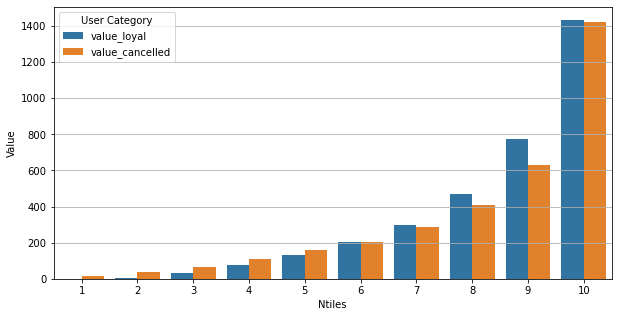

In [54]:
fig = plt.figure(figsize=(10,5))
plt.grid()
sns.barplot(y='Value', x='Ntiles', hue='User Category', data = sess_durs_pd)
plt.show()

Additionally to the N-tiles, let's analyze the histogram of session durations for both groups.

In [176]:
session_lengths2 = spark.sql('''
                              SELECT churn, userId, sessionId, to_minutes(MAX(ts)-MIN(ts)) as session_duration
                              FROM df_table
                              GROUP BY churn, userId, sessionId
                              ORDER BY userId ASC, MIN(ts) ASC
                              ''').toPandas()

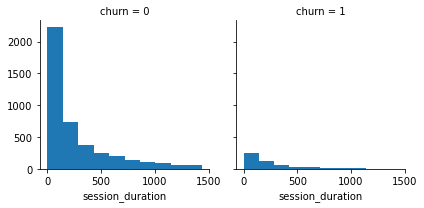

In [177]:
g = sns.FacetGrid(session_lengths2, col='churn')
g.map(plt.hist, 'session_duration')

The distribution of listening times shows that for 50% of the user base, the group of cancelled users tends to longer session durations. However, the 9-tile shows that loyal users seem to prefer longer listening sessions.

The n-tile distribution of the session lengths for a given user could be a relevant feature to classify the user as `churn`.

#### Average Click-count of pages per session

It can be assumed that loyal users tend to have a different click pattern than users that cancelled. For that, for each page, the average click count over all sessions of a given user group is calculated.

In [55]:
spark.sql("""
SELECT * FROM df_table""").toPandas()

,userId,page,level,sessionId,ts,itemInSession,userSystem,length,auth,cancel_event,churn
0,100010,NextSong,free,31,1539003534000,0,iPhone,202.97098,Logged In,0,0
1,100010,NextSong,free,31,1539003736000,1,iPhone,196.54485,Logged In,0,0
2,100010,NextSong,free,31,1539003932000,2,iPhone,263.13098,Logged In,0,0
3,100010,Thumbs Up,free,31,1539003933000,3,iPhone,NaN,Logged In,0,0
4,100010,NextSong,free,31,1539004195000,4,iPhone,316.23791,Logged In,0,0
...,...,...,...,...,...,...,...,...,...,...,...
286495,100001,Home,free,53,1538497786000,19,Macintosh,NaN,Logged In,0,1
286496,100001,NextSong,free,53,1538498032000,20,Macintosh,655.77751,Logged In,0,1
286497,100001,Roll Advert,free,53,1538498073000,21,Macintosh,NaN,Logged In,0,1
286498,100001,Cancel,free,53,1538498074000,22,Macintosh,NaN,Logged In,0,1


In [56]:
def avg_page_click_percentages(user_table):
    """
    Calculates for the given user group the average of the percentage of each `page` within a user session.
    Only such events are counted that are done in a 'Logged In' state.
    
    INPUTS:
        user_table (string): name of a temp view that contains userIds, e.g. loyal_userIds or cancelled_userIds. This is the underlying user group.
    OUTPUTS:
        result (DataFrame): A pandas DataFrame that shows the average percentage of each page over all sessions of the given user group.
    """
    # Click count for each page within each user session
    pages_per_session = spark.sql("""
          SELECT userId, sessionId, page, COUNT(page) as cnt
          FROM df_table
          WHERE userId in (SELECT * FROM {user_table}) and auth = 'Logged In'
          GROUP BY userId, sessionId, page
          """.format(user_table=user_table))
    pages_per_session.createOrReplaceTempView("pages_per_session")
    
    # Calculate the percentage of each page in each session
    tmp = spark.sql('''
                  SELECT userId, sessionId, page, cnt / SUM(cnt) OVER (PARTITION BY userId, sessionId) as sess_perc
                  FROM pages_per_session
                  ''')
    tmp.createOrReplaceTempView("tmp")
    
    # Calculate average percentage page rate within a session.
    tmp2 = spark.sql('''
          SELECT *, sess_perc / (SELECT COUNT(DISTINCT userId, sessionId) FROM tmp) as sess_avg_perc
          FROM tmp
          ''')
    tmp2.createOrReplaceTempView("tmp2")
    
    # Finally aggregate by the pages and dispay the average session percentages.
    pages_perc = spark.sql('''
                  SELECT page, SUM(sess_avg_perc) as avg_percent
                  FROM tmp2
                  GROUP BY page
                  ORDER BY avg_percent DESC
                  ''')
    return pages_perc.toPandas()

In [57]:
# Get the distributions for both user groups
loyal_avg_clk_perc_pd = avg_page_click_percentages('loyal_userIds')
cancelled_avg_clk_perc_pd = avg_page_click_percentages('cancelled_userIds')

In [58]:
avg_clk_perc_pd = merge_and_melt_dfs(loyal_avg_clk_perc_pd,
                                cancelled_avg_clk_perc_pd,
                                on='page')

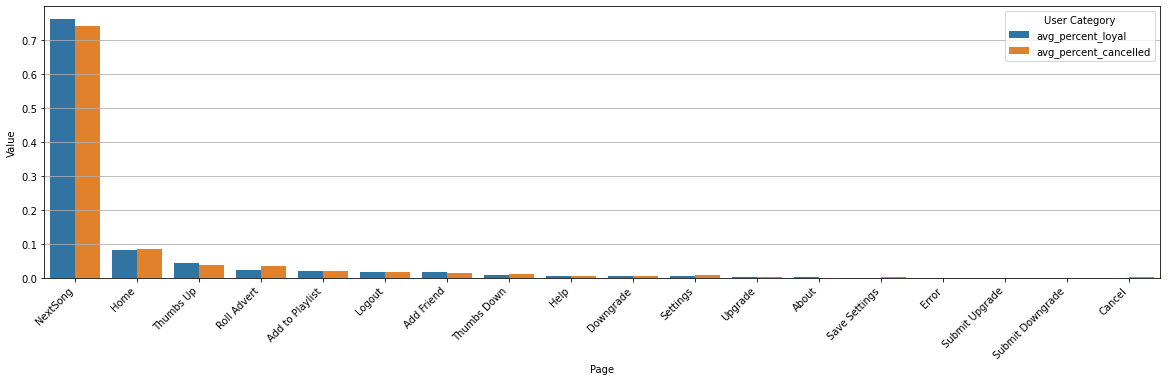

In [59]:
fig = plt.figure(figsize=(20,5))
plt.grid()
sns.barplot(y='Value', x='Page', hue='User Category', data = avg_clk_perc_pd)
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
plt.show()

The distribution looks similar, however, loyal users tend to click `NextSong` more often, whereby cancelled users tend to click on `Home` and `Roll Advert` more often.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Target for the feature extraction is to create a dataframe with one row for each user. This row contains aggregated features.

In [60]:
# DataFrame for extracted features - to be filled up below
features_df = spark.sql('''
                        SELECT userId, MAX(churn) as churn
                        FROM df_table
                        GROUP BY userId
                        ''')
features_df.createOrReplaceTempView("features_df")

In [61]:
def add_feature(sub_query, new_feature_name, new_temp_view='features_df'):
    """
    Used to add a new feature column to table 'features_df'. This
    is achieved by injecting the passed sql-subquery and joining
    the results on userId with the existing featues_df table.
    
    INPUT:
        - sub_query (string): SQL query that should contain one row of additional features for each userId.
        - new_feature_name (string): name of the new feature contained in 'sub_query'
        - new_temp_view (string): Name of the new createOrReplaceTempView resulting from the joining 
    OUTPUT:
        result (DataFrame): Spark DataFrame with the resulting table.
    """
    tmp = spark.sql("""
                    SELECT f.*, new.{new_feature_name}
                    FROM features_df as f
                    JOIN ({sub_query}) as new
                    on new.userId = f.userId
                    """.format(sub_query = sub_query,
                               new_feature_name = new_feature_name))   
    tmp.createOrReplaceTempView(new_temp_view)
    return tmp

In [62]:
# Add the feature for average sessions per day
avg_sess_per_day = """
                   SELECT userId, COUNT(DISTINCT sessionId) / (to_days(MAX(ts) - MIN(ts))+1) as avg_sess_p_day
                   FROM df_table
                   GROUP BY userId
                   """
features_df = add_feature(avg_sess_per_day, 'avg_sess_p_day')

In [112]:
# Average length
avg_length = """
             SELECT userId, avg(length) as avg_length
             FROM df_table
             GROUP BY userId
             """
features_df = add_feature(avg_length, 'avg_length')

In [116]:
# Average items per session
avg_items_p_sess = """
                      SELECT userId, AVG(itemInSession) as avg_items_p_sess
                      FROM df_table
                      GROUP BY userId
                      """
features_df = add_feature(avg_items_p_sess, 'avg_items_p_sess')

In [173]:
# Account age in days
acc_age = """
          SELECT userId, to_days(MAX(ts) - MIN(ts)) as acc_age
          FROM df_table
          GROUP BY userId
          """
features_df = add_feature(acc_age, 'acc_age')

In [196]:
# Average session length in minutes

# Create a helper table that holds all session lengths for each user in minutes
tmp_sess_lens = """
        SELECT userId, to_minutes(MAX(ts)-MIN(ts)) as len
        FROM df_table
        GROUP BY userId, sessionId
      """
tmp_sess_lens = spark.sql(tmp_sess_lens)
tmp_sess_lens.createOrReplaceTempView("tmp_sess_lens")

# Compute the average over the session lengths of each user
avg_sess_len = """
              SELECT userId, AVG(len) as avg_sess_len
              FROM tmp_sess_lens
              GROUP BY userId
              """
features_df = add_feature(avg_sess_len, 'avg_sess_len')

In [197]:
features_df.toPandas().head()

,userId,churn,avg_sess_p_day,weightCol,avg_length,avg_items_p_sess,acc_age,avg_sess_len
0,100010,0,0.155556,0.230088,243.421445,35.895013,44,154.142857
1,200002,0,0.130435,0.230088,242.916992,60.578059,45,265.833333
2,125,1,1.000000,0.769912,261.139138,5.000000,0,29.000000
3,124,0,0.483333,0.230088,248.176537,165.099275,59,379.931034
4,51,1,0.625000,0.769912,247.880551,200.603490,15,439.900000


In [64]:
# Mostly used system
# Daytimes
# Weektimes
# Average percentage of each page click

#### Handling imbalanced classes

The `churn` is highly imbalanced over the provided samples. In order to get propper classification results, according measures need to be applied. Following choices exist:
- Define a column `weightCol`, available after Spark 3.0.0
- Up- or Down-sample the classes

As at the time of writing no Docker image for Spark 3.0.0 was available, the approach of up- sampling is applied.

##### Up-sampling underrepresented classes

In order to balance the classses, the positive (`churn` = 1) examples are all used, and the set of negative examples is down-sampled according to the ratio of negative to positive samples.

In [201]:
# Extract positive and negative samples
churn_neg_samples = features_df.filter(features_df.churn == 0)
churn_pos_samples = features_df.filter(features_df.churn == 1)

# Compute counts of both sets
churn_neg_cnt = churn_neg_samples.count()
churn_pos_cnt = churn_pos_samples.count()

In [202]:
# Ratio of positive examples
pos_ratio = (float(churn_pos_cnt) / (churn_neg_cnt))

In [203]:
# Perform the sub-sampling of negative examples
sampled = churn_neg_samples.sample(False, pos_ratio)

In [204]:
# Union sub-sampled negative examples with positive examples
features_df_bal = sampled.union(churn_pos_samples)

In [205]:
# Verify the new number of negative examples
features_df_bal.filter(features_df_bal.churn == 0).count()

52

##### Weights for samples (AFTER SPARK 3.0.0)

In [70]:
# Add class weights to compensate unbalanced classes
weightCol =   """
              SELECT userId, CASE WHEN MAX(churn) = 1 
                                  THEN
                                    1 - (SELECT AVG(churn) FROM features_df)
                                  ELSE
                                    (SELECT AVG(churn) FROM features_df)
                                  END as weightCol
              FROM df_table
              GROUP BY userId
              """
features_df = add_feature(weightCol, 'weightCol')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Target of the model is to label each user as churn or no_churn. Users that churned should be detected correctly. Others should be spared out.

--> Label all churned users as 1 and try to predict this.

In [206]:
# Split data for training/test and validation
train_test, validation = features_df_bal.randomSplit([0.9, 0.1], seed=42)

In [207]:
train_test.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- avg_sess_p_day: double (nullable = true)
 |-- weightCol: double (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- avg_items_p_sess: double (nullable = true)
 |-- acc_age: integer (nullable = true)
 |-- avg_sess_len: double (nullable = true)



In [208]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# VectorAssembler
vecAssembler = VectorAssembler(inputCols=["avg_sess_p_day",
                                          "avg_length",
                                          "avg_items_p_sess",
                                          "acc_age",
                                          "avg_sess_len"],
                               outputCol="features")

# Normalizer / Scaler
maScaler = MaxAbsScaler(inputCol="features",
                        outputCol="features_scaled")

# Create the model
svm = LinearSVC(featuresCol='features_scaled',
                labelCol='churn', 
                predictionCol='prediction')

# Fit the model

In [209]:
# Define a pipeline
pipe = Pipeline(stages=[vecAssembler,
                        maScaler,
                        svm])

grid = ParamGridBuilder().addGrid(svm.regParam, [0]).build()

# Use cross-validation
cv = CrossValidator(estimator=pipe,
                    evaluator=MulticlassClassificationEvaluator(labelCol='churn',
                                                                #rawPredictionCol='Prediction',
                                                                metricName='f1'),
                    estimatorParamMaps=grid,
                    numFolds=3,
                    parallelism=4)

In [210]:
cvModel = cv.fit(train_test)

In [211]:
import pathlib
model_path = str(pathlib.Path().absolute() / "model" / "svm")

In [212]:
import tempfile
cvModel.bestModel.write().overwrite().save(model_path)

Unclear what this means - is it accurracy for each parameter combination of the grid? If yes, 0.5 means it is just randomly right?

In [220]:
results2 = cvModel.transform(train_test)

In [221]:
results2.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- avg_sess_p_day: double (nullable = true)
 |-- weightCol: double (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- avg_items_p_sess: double (nullable = true)
 |-- acc_age: integer (nullable = true)
 |-- avg_sess_len: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [222]:
results2.filter((results2.churn == 1)).count()/results2.count()

0.49473684210526314

The classificator just always says 'no churn' and achieves an accuracy of 81% with that strategy.

In [223]:
results2.count()

95

In [224]:
cv.getEvaluator().evaluate(results2, {cv.getEvaluator().metricName: "accuracy"})

0.8736842105263158

In [225]:
cv.getEvaluator().evaluate(results2, {cv.getEvaluator().metricName: "f1"})

0.8736001494419279

Only 44% of all samples are labeled correctly

In [87]:
from pyspark.ml.classification import NaiveBayes

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.